In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import sys
import os

In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(src_path)
from preprocessing import preprocessing
from model import model_results

In [3]:
df_merged = preprocessing(
    "../data/Export_TBL_MVA.xlsx", "../data/Export_Packstuecke_MVA.xlsx"
)

c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\src\preprocessing.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["PACKAGE_DENSITY"].fillna(mean_package_density, inplace=True)


In [4]:
numerical_columns = [
    # "PACKAGE_VOLUME",
    "PACKAGE_DENSITY",
    "TIME_DIFF_VERPACKT_TO_LIEFERSCHEIN",
    "TIME_DIFF_LIEFERSCHEIN_TO_BEREITGESTELLT",
    "TIME_DIFF_BEREITGESTELLT_TO_TA",
    "HOUR_OF_DAY_EINGANG",
    "HOUR_OF_DAY_VERPACKT",
    "HOUR_OF_DAY_LIEFERSCHEIN",
    "HOUR_OF_DAY_BEREITGESTELLT",
    "HOUR_OF_DAY_TA",
    "PROCESSING_TIME_DURATION",
]

          COUNTRY     PRIORITY  PACKAGE_TYPE  PACKAGE_DENSITY  \
count  2935.00000  2935.000000   2935.000000      2935.000000   
mean      7.29983     1.377513      1.388756       188.840511   
std       2.71079     0.748030      0.936903       119.649922   
min       0.00000     1.000000      0.000000         0.159091   
25%       7.00000     1.000000      1.000000       100.000000   
50%       7.00000     1.000000      1.000000       154.897186   
75%       7.00000     1.000000      1.000000       249.703828   
max      25.00000     3.000000      4.000000       560.000000   

       PROCESSING_TIME_DURATION  TIME_DIFF_VERPACKT_TO_LIEFERSCHEIN  \
count               2935.000000                         2935.000000   
mean                  61.833154                           40.887923   
std                   46.875585                           41.158694   
min                    0.116667                            0.022500   
25%                   24.623194                            

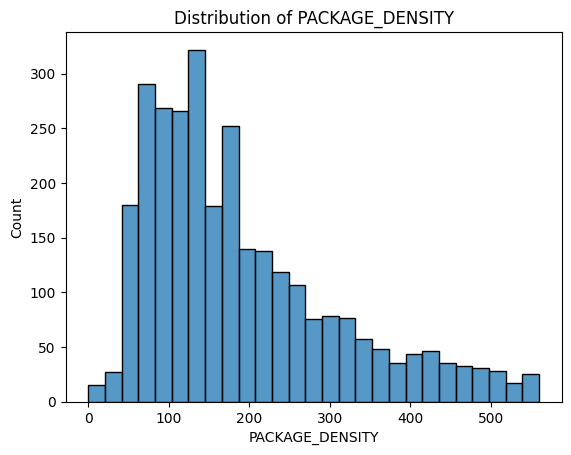

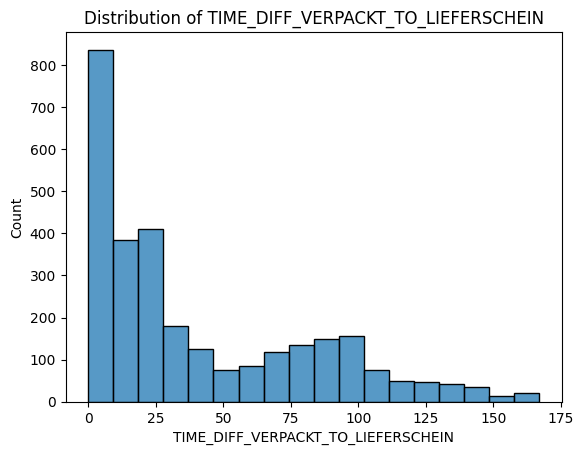

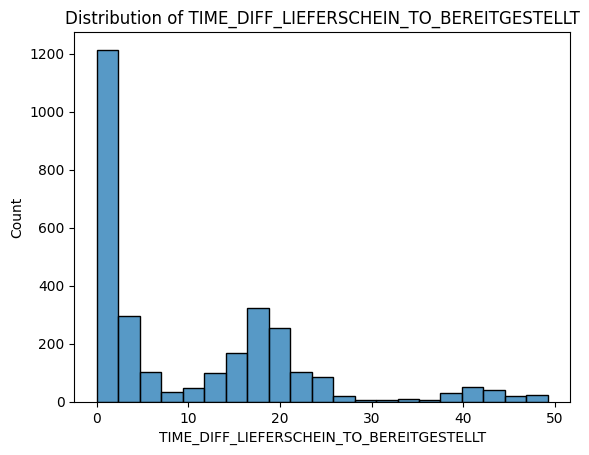

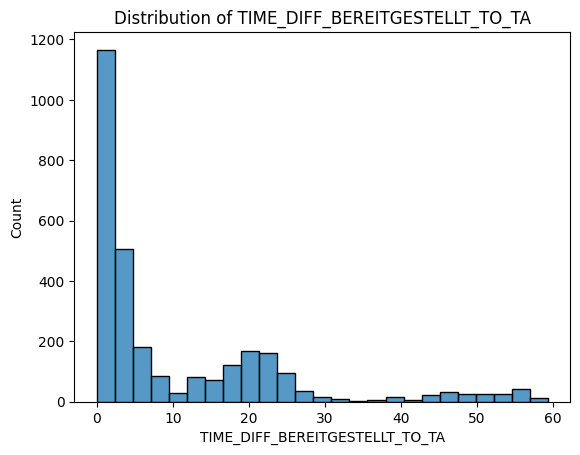

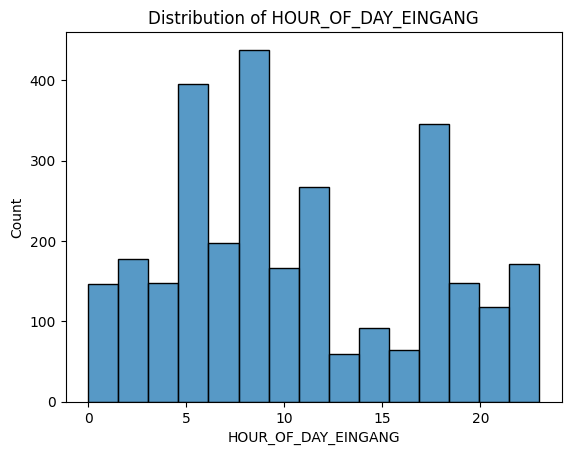

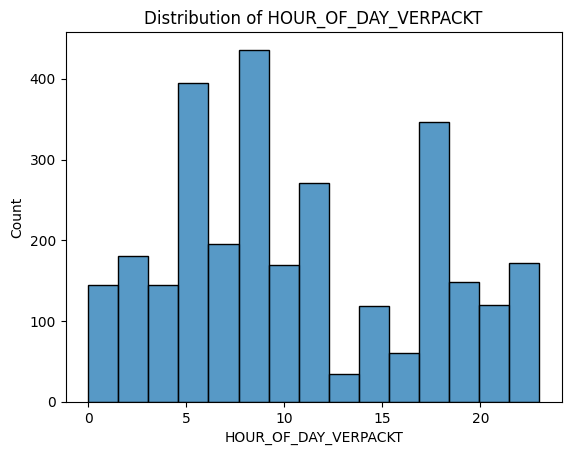

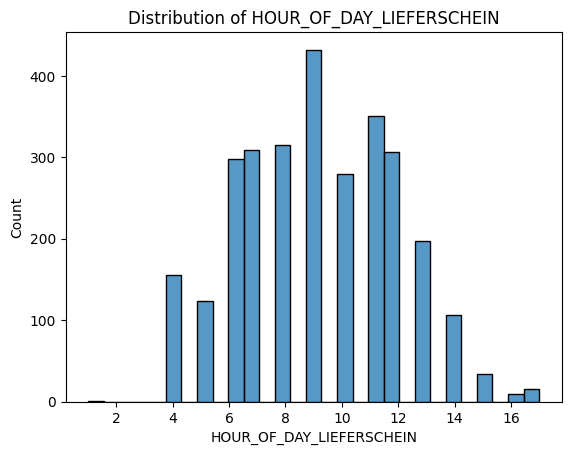

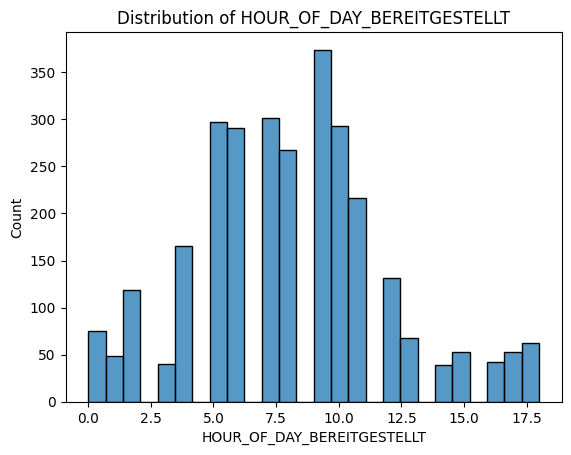

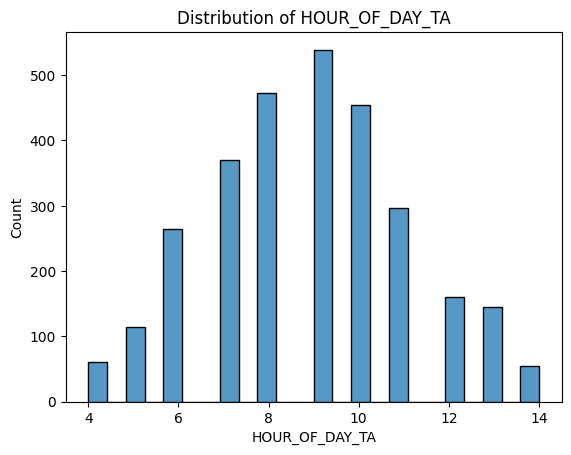

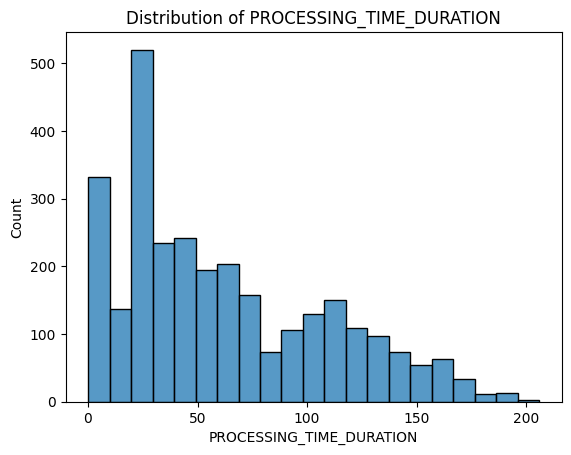

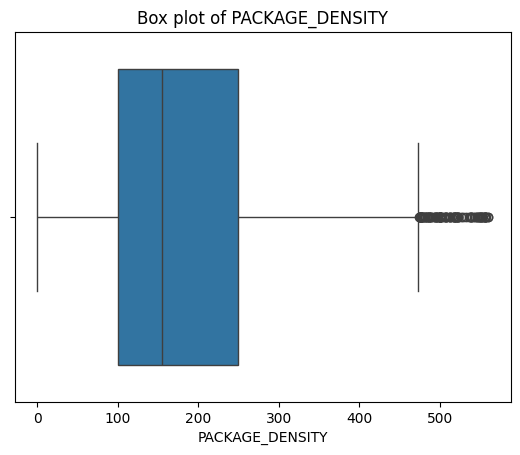

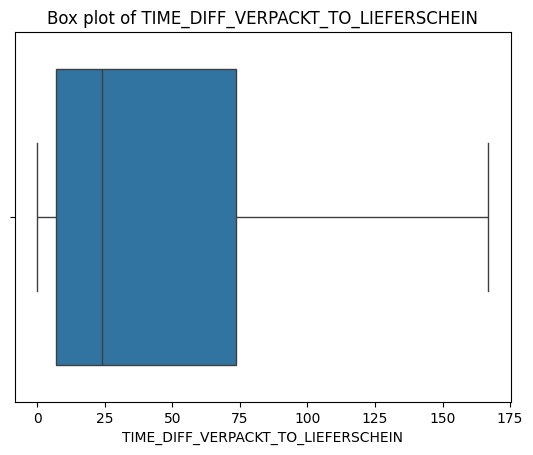

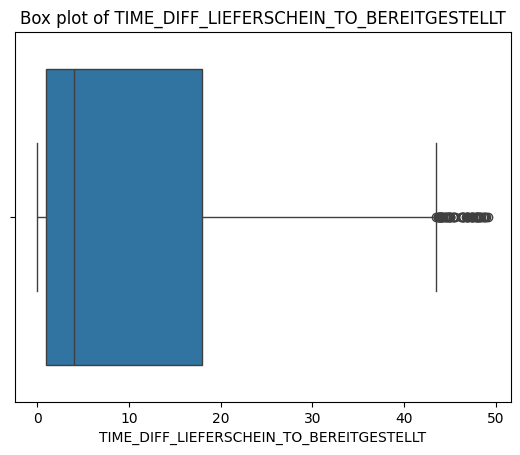

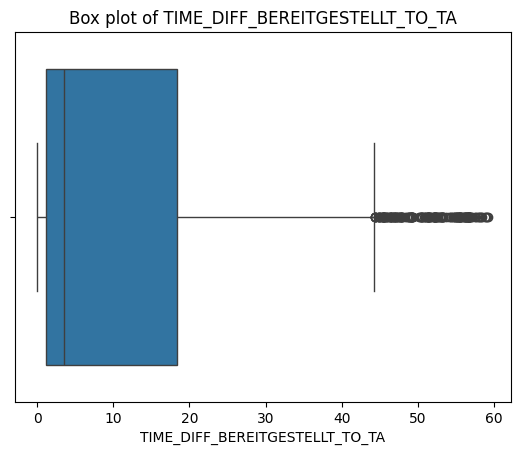

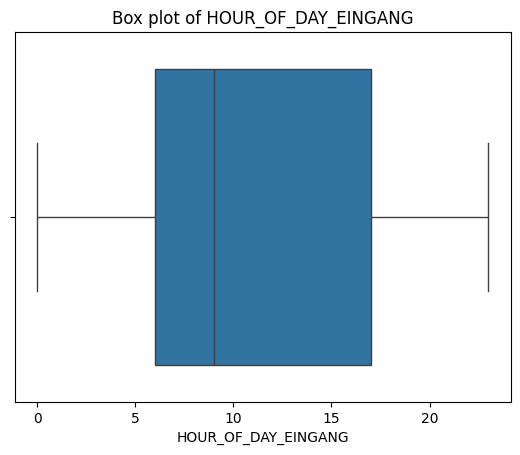

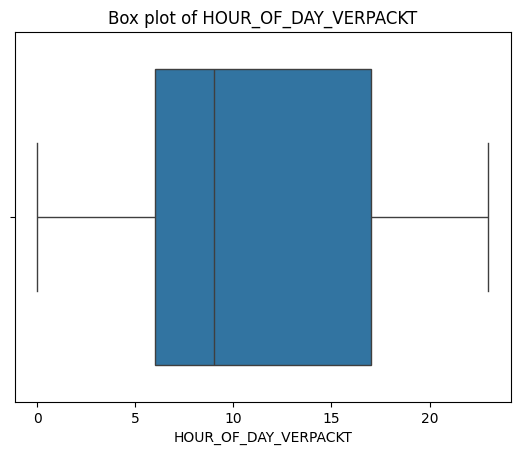

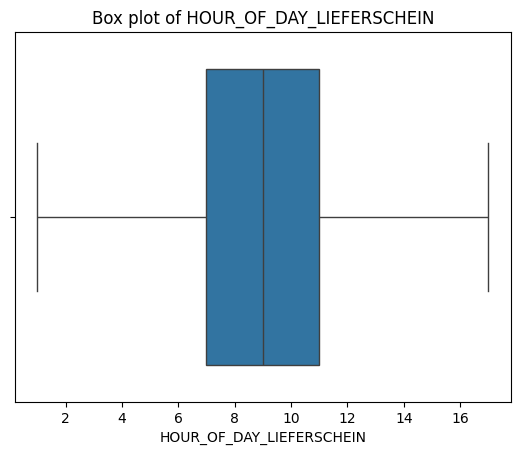

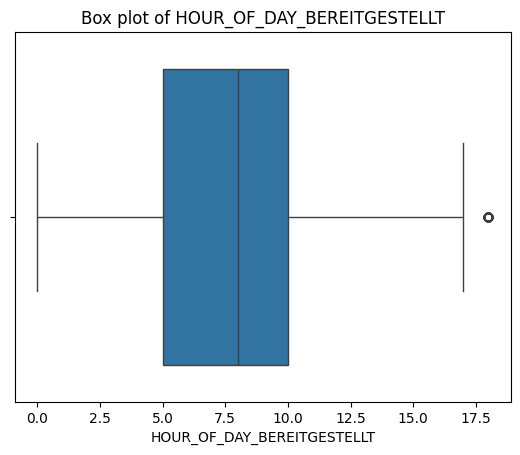

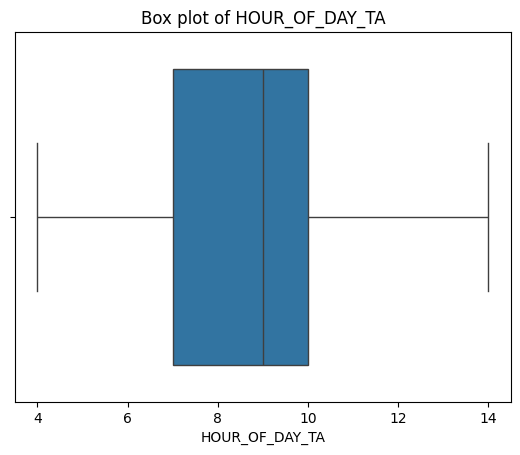

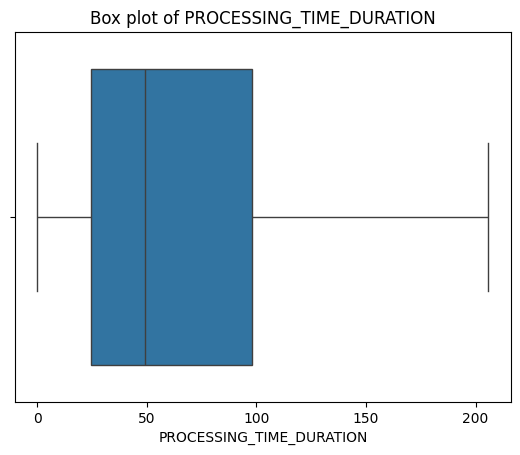

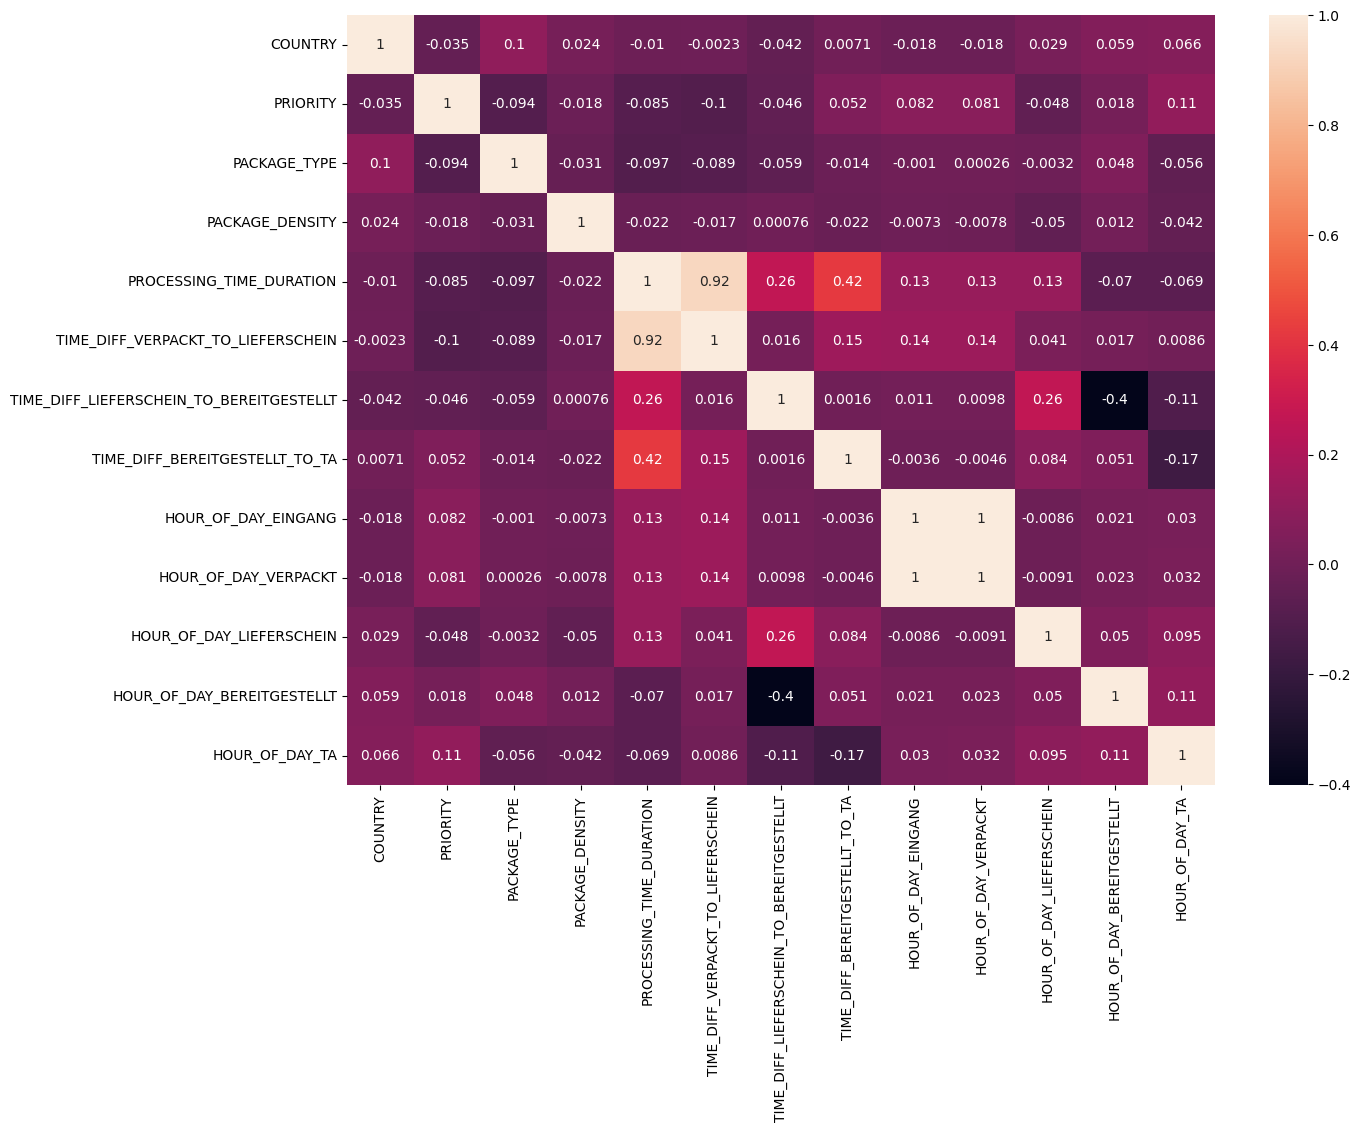

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Descriptive statistics
print(df_merged.describe())


for col in numerical_columns:
    sns.histplot(df_merged[col])
    plt.title(f"Distribution of {col}")
    plt.show()

# Box plots for numerical columns
for col in numerical_columns:
    sns.boxplot(x=df_merged[col])
    plt.title(f"Box plot of {col}")
    plt.show()


# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df_merged.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [6]:
categorical_columns = ["COUNTRY", "PRIORITY", "PACKAGE_TYPE"]

for col in categorical_columns:
    value_counts = df_merged[col].value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log2(value_counts))
    print(f"Entropy for {col}: {entropy}")

Entropy for COUNTRY: 0.8349373454022813
Entropy for PRIORITY: 0.9251581106931503
Entropy for PACKAGE_TYPE: 1.3068016150388486


In [7]:
X = df_merged.drop("PROCESSING_TIME_DURATION", axis=1)  # Features
y = df_merged["PROCESSING_TIME_DURATION"]  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

mae_xgb :  1.2033703230477961  r2_xgb :  0.9976263727509349  mse_xgb :  4.878815416957848
Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=  10.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   8.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   8.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   8.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   8.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   6.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  12.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   9.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  12.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   9.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   9.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  12.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   6.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  12.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   6.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   5.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   6.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  11.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   6.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   6.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=  10.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=  10.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  10.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  10.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=  10.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=  10.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  10.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  10.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   5.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   9.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   9.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   9.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   9.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   8.2s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  16.1s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  17.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  15.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   2.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   5.3s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   4.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   9.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   8.9s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   4.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   8.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=   7.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.7s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   3.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=   7.6s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.5s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=constant, max_iter=1000, random_state=42, solver=adam; total time=  17.0s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam; total time=   7.4s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.8s


c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=1000, random_state=42, solver=adam; total time=  14.9s
mse_mlp :  0.03654607116726714  mae_mlp :  0.1378348642366144  r2_mlp :  0.9999822197105331


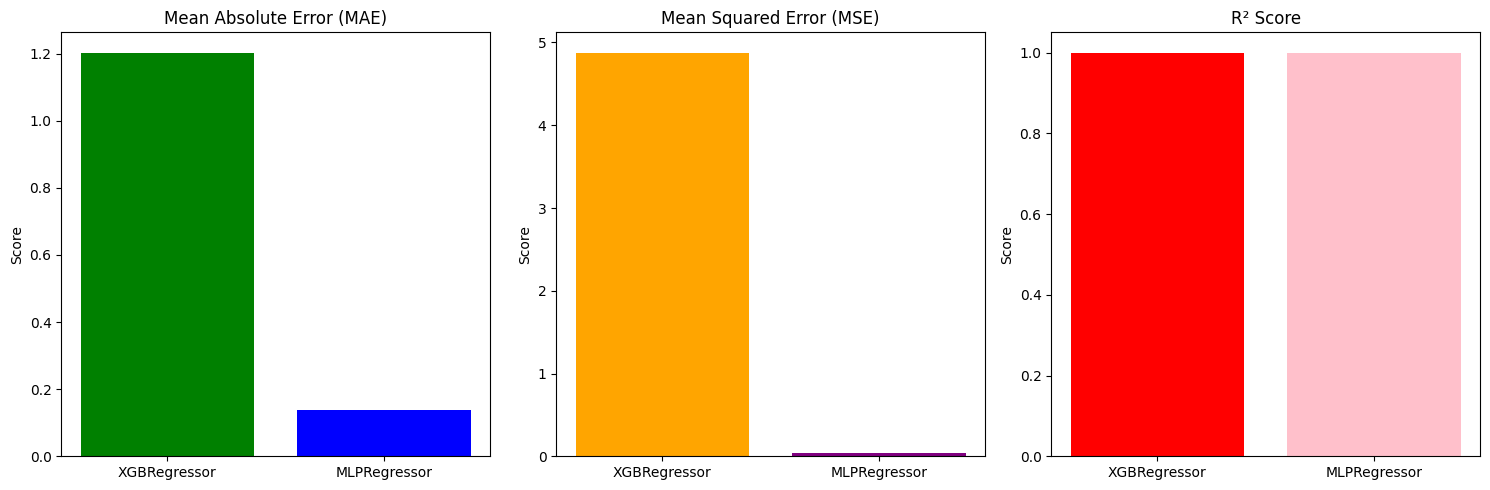

In [8]:
best_model = model_results(X_train, X_test, y_train, y_test)

In [9]:
def model_summary(mlp_model):
    print("Model parameters:")
    print(f"Hidden layer sizes: {mlp_model.hidden_layer_sizes}")
    print(f"Activation function: {mlp_model.activation}")
    print(f"Solver: {mlp_model.solver}")
    print(f"Number of iterations: {mlp_model.max_iter}")

    print("\nModel coefficients and intercepts:")
    for i, (coef, intercept) in enumerate(zip(mlp_model.coefs_, mlp_model.intercepts_)):
        print(f"Layer {i + 1} weights shape: {coef.shape}")
        print(f"Layer {i + 1} intercepts shape: {intercept.shape}")

    print("\nOther details:")
    print(f"Number of layers: {mlp_model.n_layers_}")
    print(f"Number of outputs: {mlp_model.n_outputs_}")
    print(f"Output activation function: {mlp_model.out_activation_}")


model_summary(best_model)

Model parameters:
Hidden layer sizes: (128, 64)
Activation function: tanh
Solver: adam
Number of iterations: 1000

Model coefficients and intercepts:
Layer 1 weights shape: (12, 128)
Layer 1 intercepts shape: (128,)
Layer 2 weights shape: (128, 64)
Layer 2 intercepts shape: (64,)
Layer 3 weights shape: (64, 1)
Layer 3 intercepts shape: (1,)

Other details:
Number of layers: 4
Number of outputs: 1
Output activation function: identity
